In [1]:
# The only change fron Test_Indicator_T4 is on the time sereies change.

In [3]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.12.0


## Hyperparameters

In [4]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load GBPUSD data

In [5]:

names=['Date','Open', 'High', 'Low', 'Close', 'Volume']
import pandas_ta as ta

df = pd.read_csv('/home/khaled.dawoud/Desktop/LSTM_Project/Transformer/Transformer_Daily/GBPUSD_25_4_23.csv', header=None, names=names)
indicators=pd.DataFrame()
GT_Data=pd.DataFrame()
GT_Data['Values']= df['Close']- df['Open']
y= pd.DataFrame()

df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
y['Next_Close']=df['Close'][10:]
y['Next_Close']=y['Next_Close'].shift(-1)
indicators['RSI']=ta.rsi(df.Close, length=10)
# indicators['EMAF']=ta.ema(df.Close, length=20)
# indicators['EMAM']=ta.ema(df.Close, length=100)
# indicators['EMAS']=ta.ema(df.Close, length=150)

df[['Close', 'Volume']] = df[['Close', 'Volume']].rolling(11).mean() 
df = df.drop(['Date','Open', 'High', 'Low'], axis=1)

# df.sort_values('Date', inplace=True)
# df.tail()

In [6]:
GT_Data['Values']=GT_Data['Values'][10:]

In [7]:
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
indicators.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
GT_Data.dropna(how='any', axis=0, inplace=True) 

In [8]:
GT_Data

,Values
10,0.00520
11,0.01670
12,-0.00030
13,0.00050
14,-0.00580
...,...
7716,0.00113
7717,0.00035
7718,0.00035
7719,0.00434


In [9]:
GT_Data['Values']=GT_Data['Values'][1:]  # adjusting the values frame to the GT
GT_Data.dropna(how='any', axis=0, inplace=True) 

In [10]:
GT_Data['Values']

11      0.01670
12     -0.00030
13      0.00050
14     -0.00580
15     -0.01440
         ...   
7716    0.00113
7717    0.00035
7718    0.00035
7719    0.00434
7720   -0.00560
Name: Values, Length: 7710, dtype: float64

In [12]:
print(df.shape)
print(indicators.shape)
print(GT_Data.shape)


(7711, 2)
(7711, 1)
(7710, 1)


In [13]:
data=pd.concat([df, indicators], axis=1)

In [14]:
data

,Close,Volume,RSI
10,1.539536,2561.000000,59.123649
11,1.542100,2565.545455,69.044338
12,1.545573,2592.818182,67.446732
13,1.547600,2469.181818,67.638732
14,1.549418,2532.818182,60.383889
...,...,...,...
7716,1.243482,131148.636364,56.280027
7717,1.243334,113426.909091,56.824005
7718,1.243385,102169.545455,56.865852
7719,1.244000,99245.272727,61.059412


In [15]:
data['Close']=data['Close'].pct_change()
data['RSI']=data['RSI'].pct_change()
data['Volume']=data['Volume'].pct_change()
data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
y_scaled= sc.fit_transform(y)
print(data_scaled)
print(y_scaled)

[[0.72477496 0.10369052 0.41625583]
 [0.75360634 0.10554638 0.30933675]
 [0.70740303 0.09332532 0.32388808]
 ...
 [0.64499877 0.08251907 0.32270638]
 [0.66723726 0.09732025 0.36358944]
 [0.65882259 0.09755183 0.24759342]]
[[0.47520601]
 [0.47395306]
 [0.47424221]
 ...
 [0.17291697]
 [0.16742326]
 [       nan]]


In [17]:
data_scaled

array([[0.72477496, 0.10369052, 0.41625583],
       [0.75360634, 0.10554638, 0.30933675],
       [0.70740303, 0.09332532, 0.32388808],
       ...,
       [0.64499877, 0.08251907, 0.32270638],
       [0.66723726, 0.09732025, 0.36358944],
       [0.65882259, 0.09755183, 0.24759342]])

In [18]:
y.shape

(7711, 1)

In [19]:
columns=['Close','Volume','RSI']
df = pd.DataFrame(data_scaled, columns=columns)


In [20]:
df.shape # checking the shape of this dataframe

(7710, 3)

In [21]:
GT_Data.shape # checking the shape of this dataframe,( sanity check)

(7710, 1)

## Plot daily GBPUSD closing prices and volume

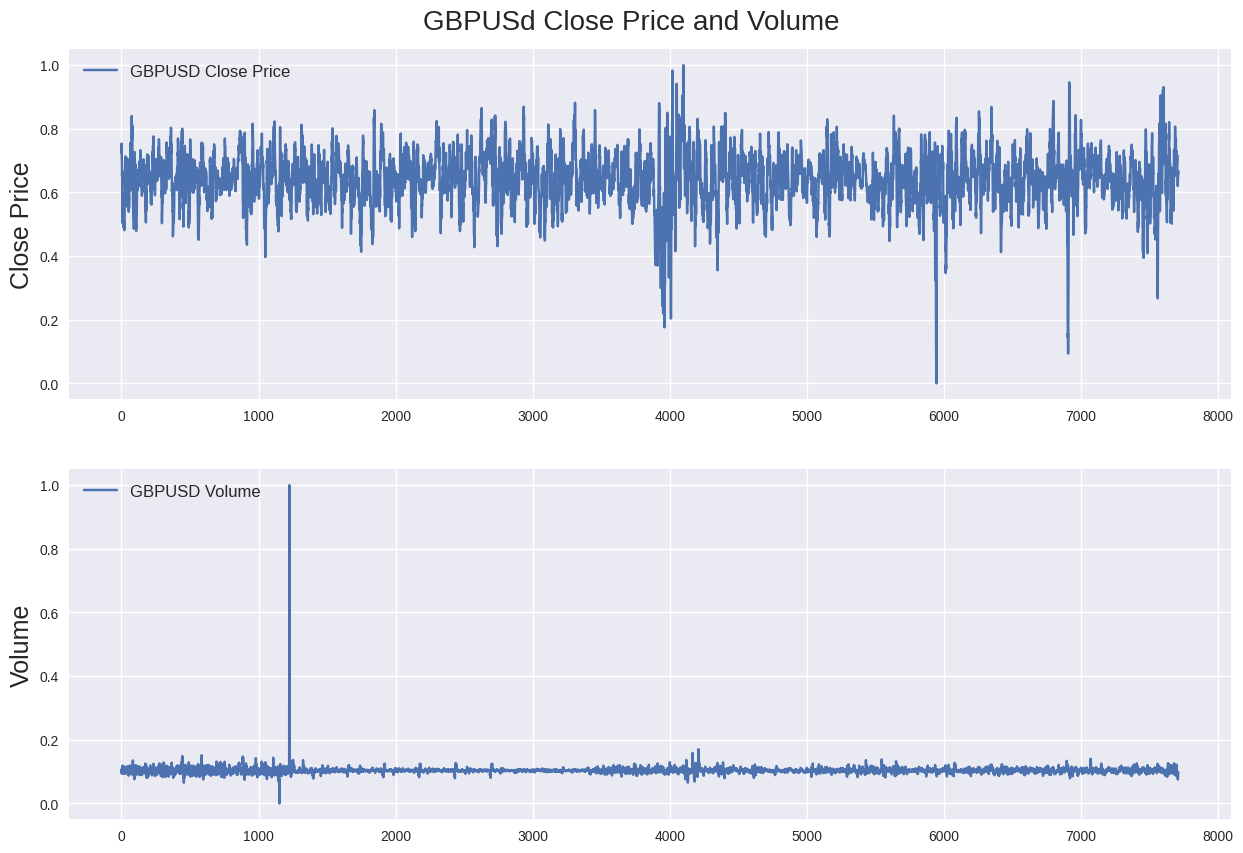

In [22]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("GBPUSd Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='GBPUSD Close Price')
#ax1.set_xticks(range(0, df.shape[0], 1464))
#ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='GBPUSD Volume')
#ax2.set_xticks(range(0, df.shape[0], 1464))
#ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [23]:
###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (6168, 3)
Validation data shape: (771, 3)
Test data shape: (771, 3)


,Close,Volume,RSI
0,0.724775,0.103691,0.416256
1,0.753606,0.105546,0.309337
2,0.707403,0.093325,0.323888
3,0.700680,0.108720,0.262231
4,0.653042,0.101588,0.181505


## Plot daily changes of close prices and volume

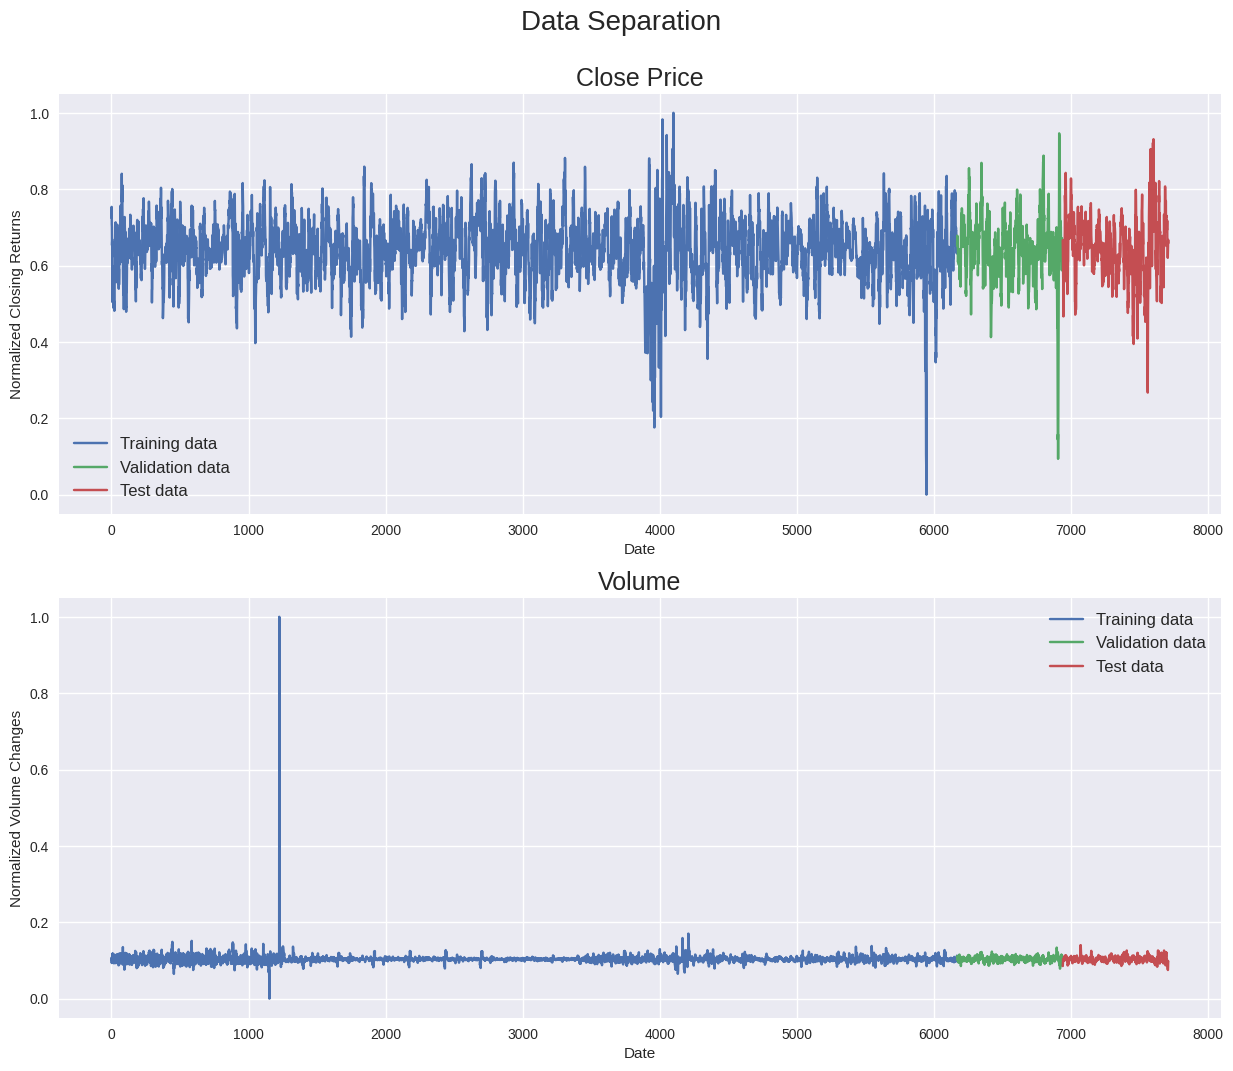

In [25]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [26]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (6040, 128, 3) (6040,)
Validation set shape (643, 128, 3) (643,)
Testing set shape (643, 128, 3) (643,)


## TimeVector

In [27]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:2], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [28]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [29]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 3))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)


## uncomment the below lines to train the model

# history = model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=35, 
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val))  



2023-12-02 21:41:11.262979: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 5)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 5)      73502       ['concatenate[0][0]',        

21/21 [==============================] - 5s 245ms/step
 
Evaluation metrics
Training Data - Loss: 0.0024, MAE: 0.0400, MAPE: 31818.8613
Validation Data - Loss: 0.0033, MAE: 0.0437, MAPE: 7.3881
Test Data - Loss: 0.0026, MAE: 0.0415, MAPE: 6.8658


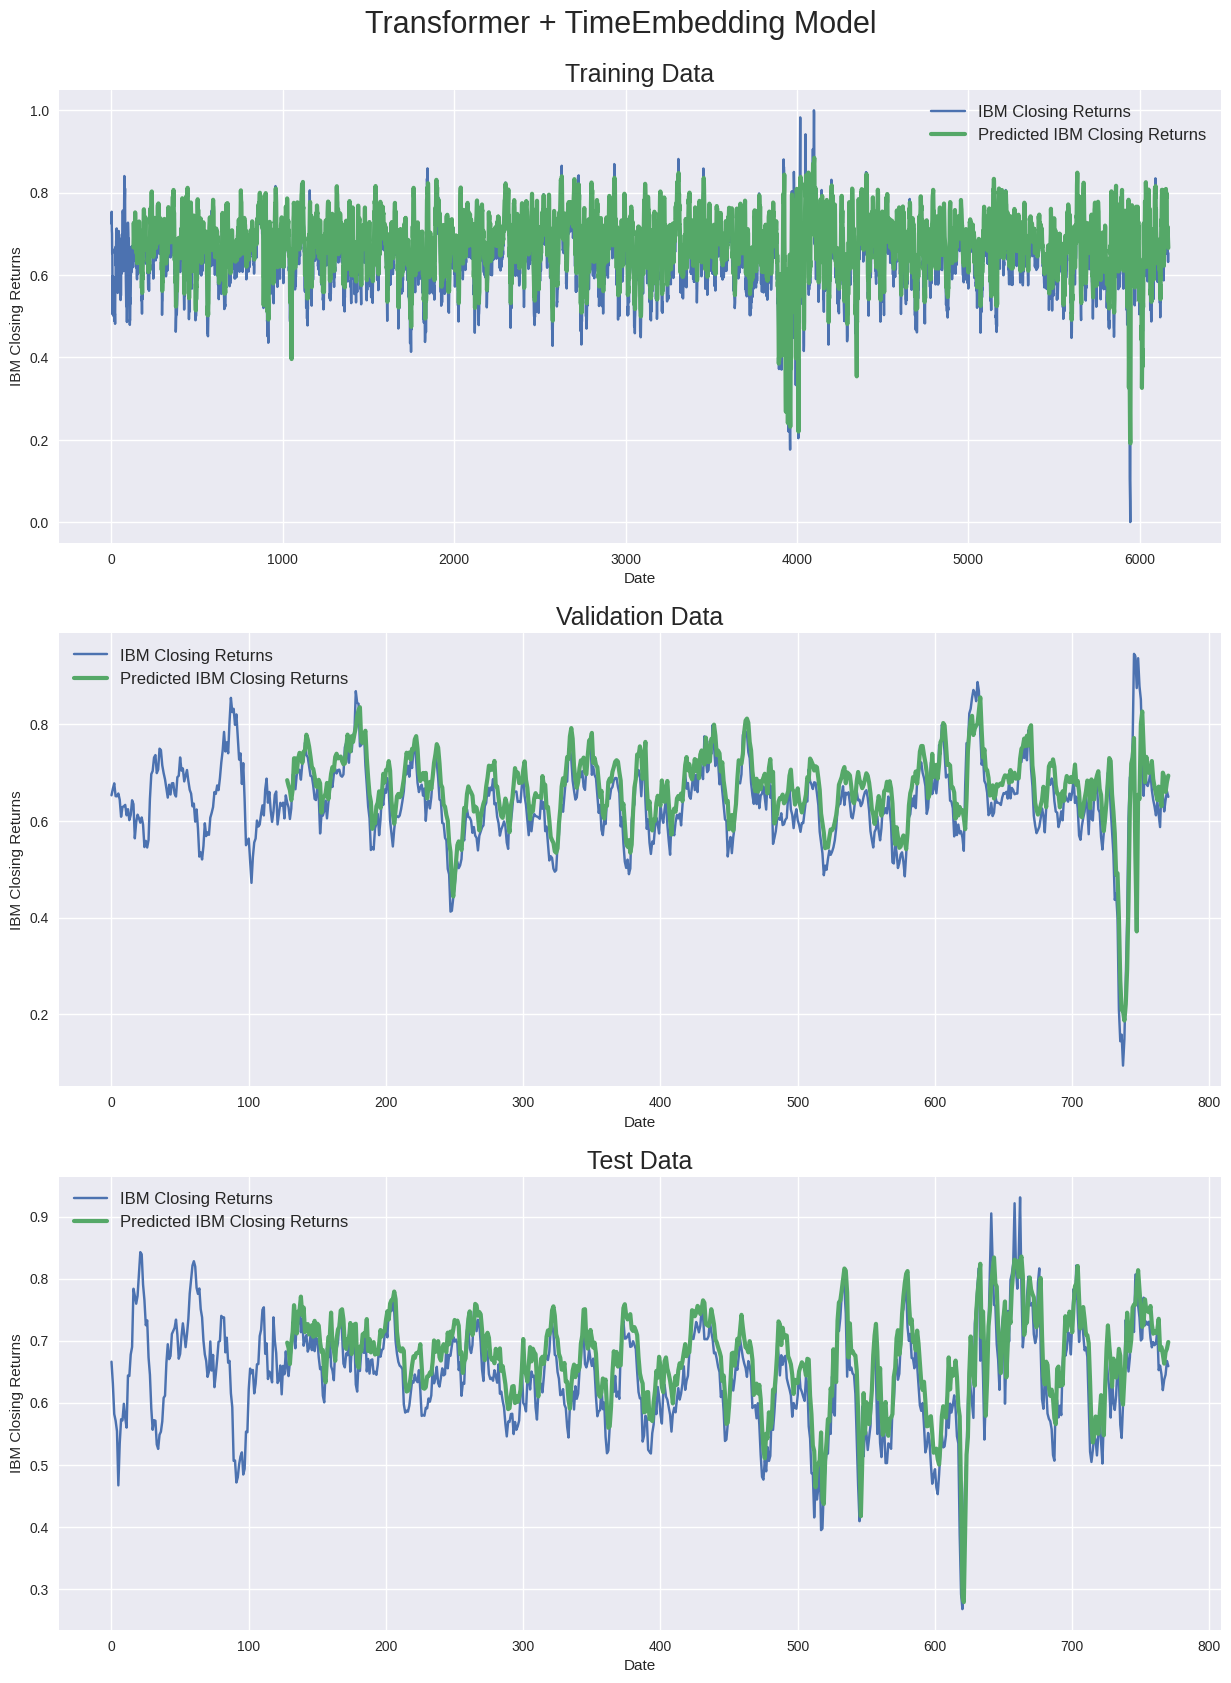

In [31]:
model = tf.keras.models.load_model('/home/khaled.dawoud/Desktop/LSTM_Project/Transformer/Transformer_Daily/2_5_23/Transformer_GBPUSD_Reduced_Y_Not_Averaged_NoValid_V1.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='GBPUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted GBPUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('GBPUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='GBPUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted GBPUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('GBPUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='GBPUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted GBPUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('GBPUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

In [30]:
MY_GT=data_scaled[:,0]
MY_GT1=MY_GT[-643:]
MY_GT1.shape
test_pred=test_pred[:,0]
R1=test_pred-MY_GT1
R1.shape
R1=R1[0:-1]
R1=np.where(R1 > 0, 1, 0)
print(R1.shape)
GT_Binary=GT_Data['Values'].values
GT_Binary=np.where(GT_Binary > 0, 1, 0)
GT_Binary=GT_Binary[-642:]
GT_Binary=np.array(GT_Binary)
Perceision=np.sum(R1==GT_Binary)
Perceision

In [ ]:
# is equal to my prediction
a=[]
for i in range(len(test_pred)):
    if test_pred[i] > MY_GT1[i]:
        a.append(1)
    elif test_pred[i] < MY_GT1[i]:
        a.append(0)

In [ ]:
# is equal to my prediction
a=[]
for i in range(len(test_pred)):
    if i == len(test_pred)-1:
        continue
    if test_pred[i] > test_pred[i]:
        a.append(1)
    elif test_pred[i+1] < test_pred[i]:
        a.append(0)
    else:
        a.append(2)

In [ ]:
# is equal to my prediction
a=[]
for i in range(len(test_pred)):
    if i == len(test_pred)-1:
        continue
    if test_pred[i+1] > test_pred[i]:
        a.append(1)
    elif test_pred[i+1] < test_pred[i]:
        a.append(0)
    else:
        a.append(2)

In [51]:
GT_Binary=GT_Data['Values'].values

In [52]:
GT_Binary.shape

(7710,)

In [ ]:
len(a)

In [53]:
GT_Binary=np.where(GT_Binary > 0, 1, 0)

In [54]:
GT_Binary=GT_Binary[-642:]

In [55]:
GT_Binary=np.array(GT_Binary)

In [56]:
GT_Binary.shape

(642,)

In [57]:
Perceision=np.sum(R1==GT_Binary)

In [58]:
Perceision

324

In [ ]:
max(a)

In [60]:

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your ground truth and predicted labels, respectively
# You may need to adjust the average parameter depending on the problem you are trying to solve
precision = precision_score(GT_Binary, R1, average='binary')
print(precision)

tn, fp, fn, tp = confusion_matrix(GT_Binary, R1).ravel()
precision1 = tp / (tp + fp)
print(precision1)
print(tp)
print(fp)
print(tn)
print(fn)

0.516728624535316
0.516728624535316
278
260
46
58


In [ ]:
import numpy as np
from collections import Counter

counts = Counter(GT_Binary)
for value, count in counts.items():
    print(f"{value}: {count}")


In [ ]:
import numpy as np
from collections import Counter

counts = Counter(a)
for value, count in counts.items():
    print(f"{value}: {count}")

<Axes: >

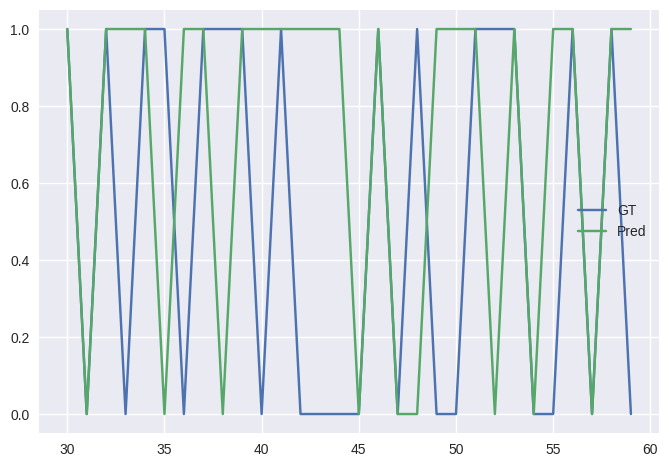

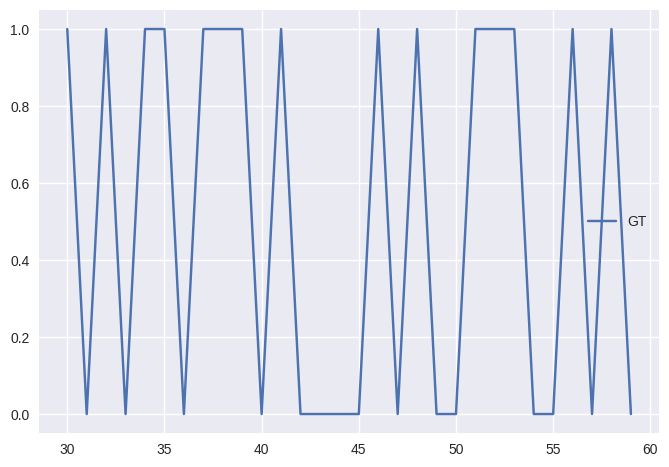

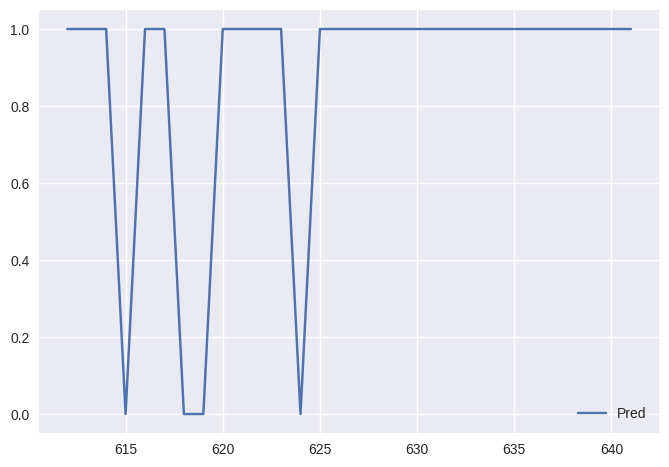

In [62]:
combined=pd.DataFrame()
GT_Binary=pd.DataFrame(GT_Binary,columns=['GT'])
a=pd.DataFrame(R1,columns=['Pred'])
combined = pd.concat([GT_Binary, a], axis=1)
combined[30:60].plot()
GT_Binary[30:60].plot()
a[-30:].plot()